In [1]:
from large_gcs.graph.cost_factory import create_l2norm_edge_cost, create_l2norm_squared_edge_cost
from large_gcs.example_graphs.utils.spp_shape_gcs_utils import generate_spp_shape_gcs, load_spp_shape_gcs, SppShapeGcsGeneratorParams
import matplotlib.pyplot as plt
import os
import numpy as np

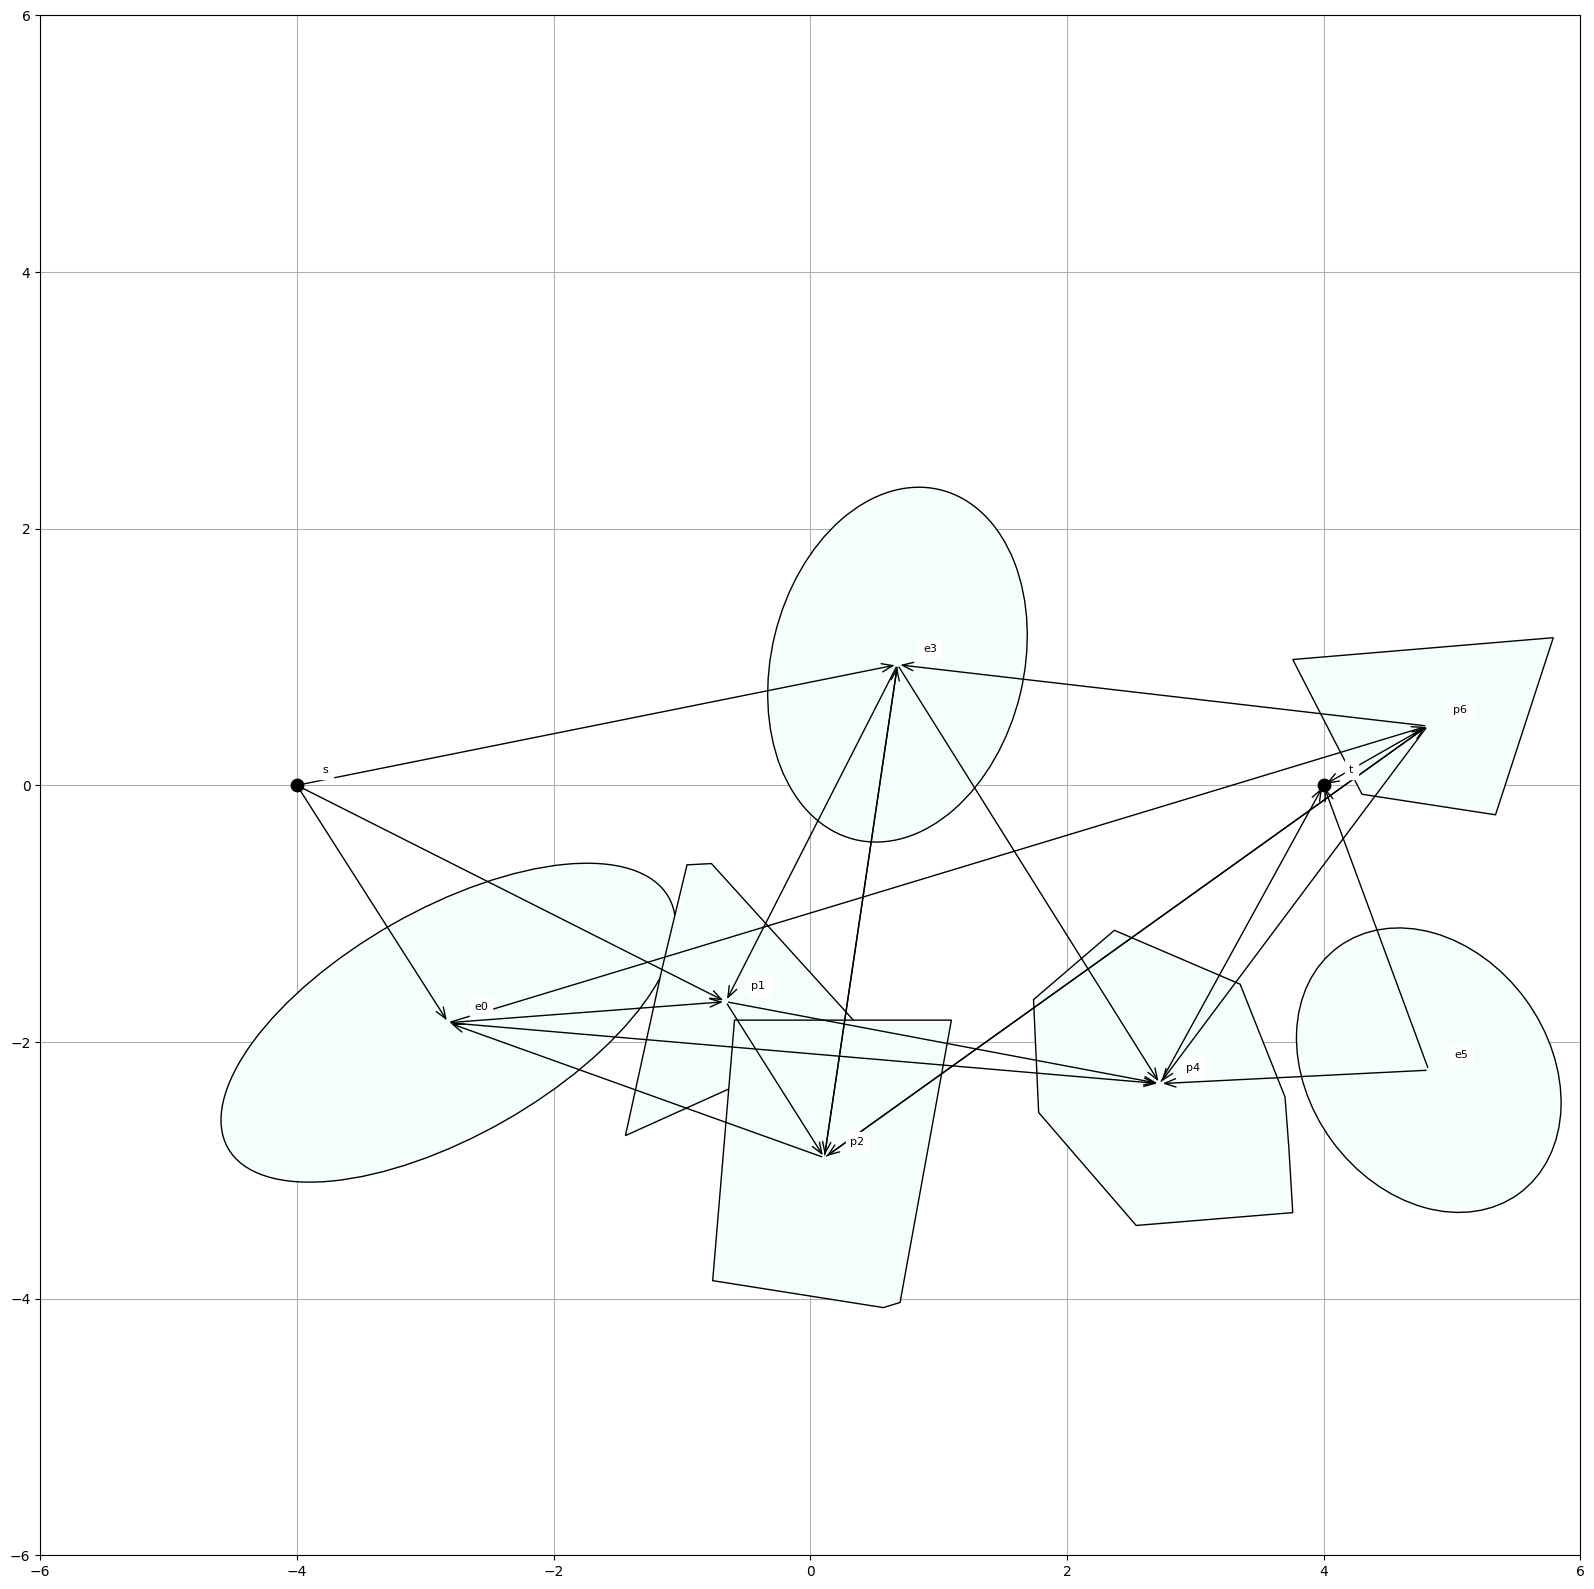

In [2]:
params = SppShapeGcsGeneratorParams(should_save=True,
                                    random_seed = 804454)
# params = SppShapeGcsGeneratorParams(
#     n_sets=100,
#     workspace=([-25, 25], [-25, 25]),
#     source=(0,0),
#     target=(15,15),
#     set_scale=1.2,
#     k_nearest_edges=(1,4),
#     k_nearest_pool=20,
#     random_seed=490052,
#     should_save=True,
# )
file = os.path.join(os.environ['PROJECT_ROOT'], "large_gcs", "example_graphs",
                    f"spp_{params.dim}d_v{params.n_sets}_shape_gcs.npy")
params.save_path = file

G = generate_spp_shape_gcs(params)

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
plt.grid()
plt.xlim(params.workspace[0]* 1.2)
plt.ylim(params.workspace[1]* 1.2)
plt.show()

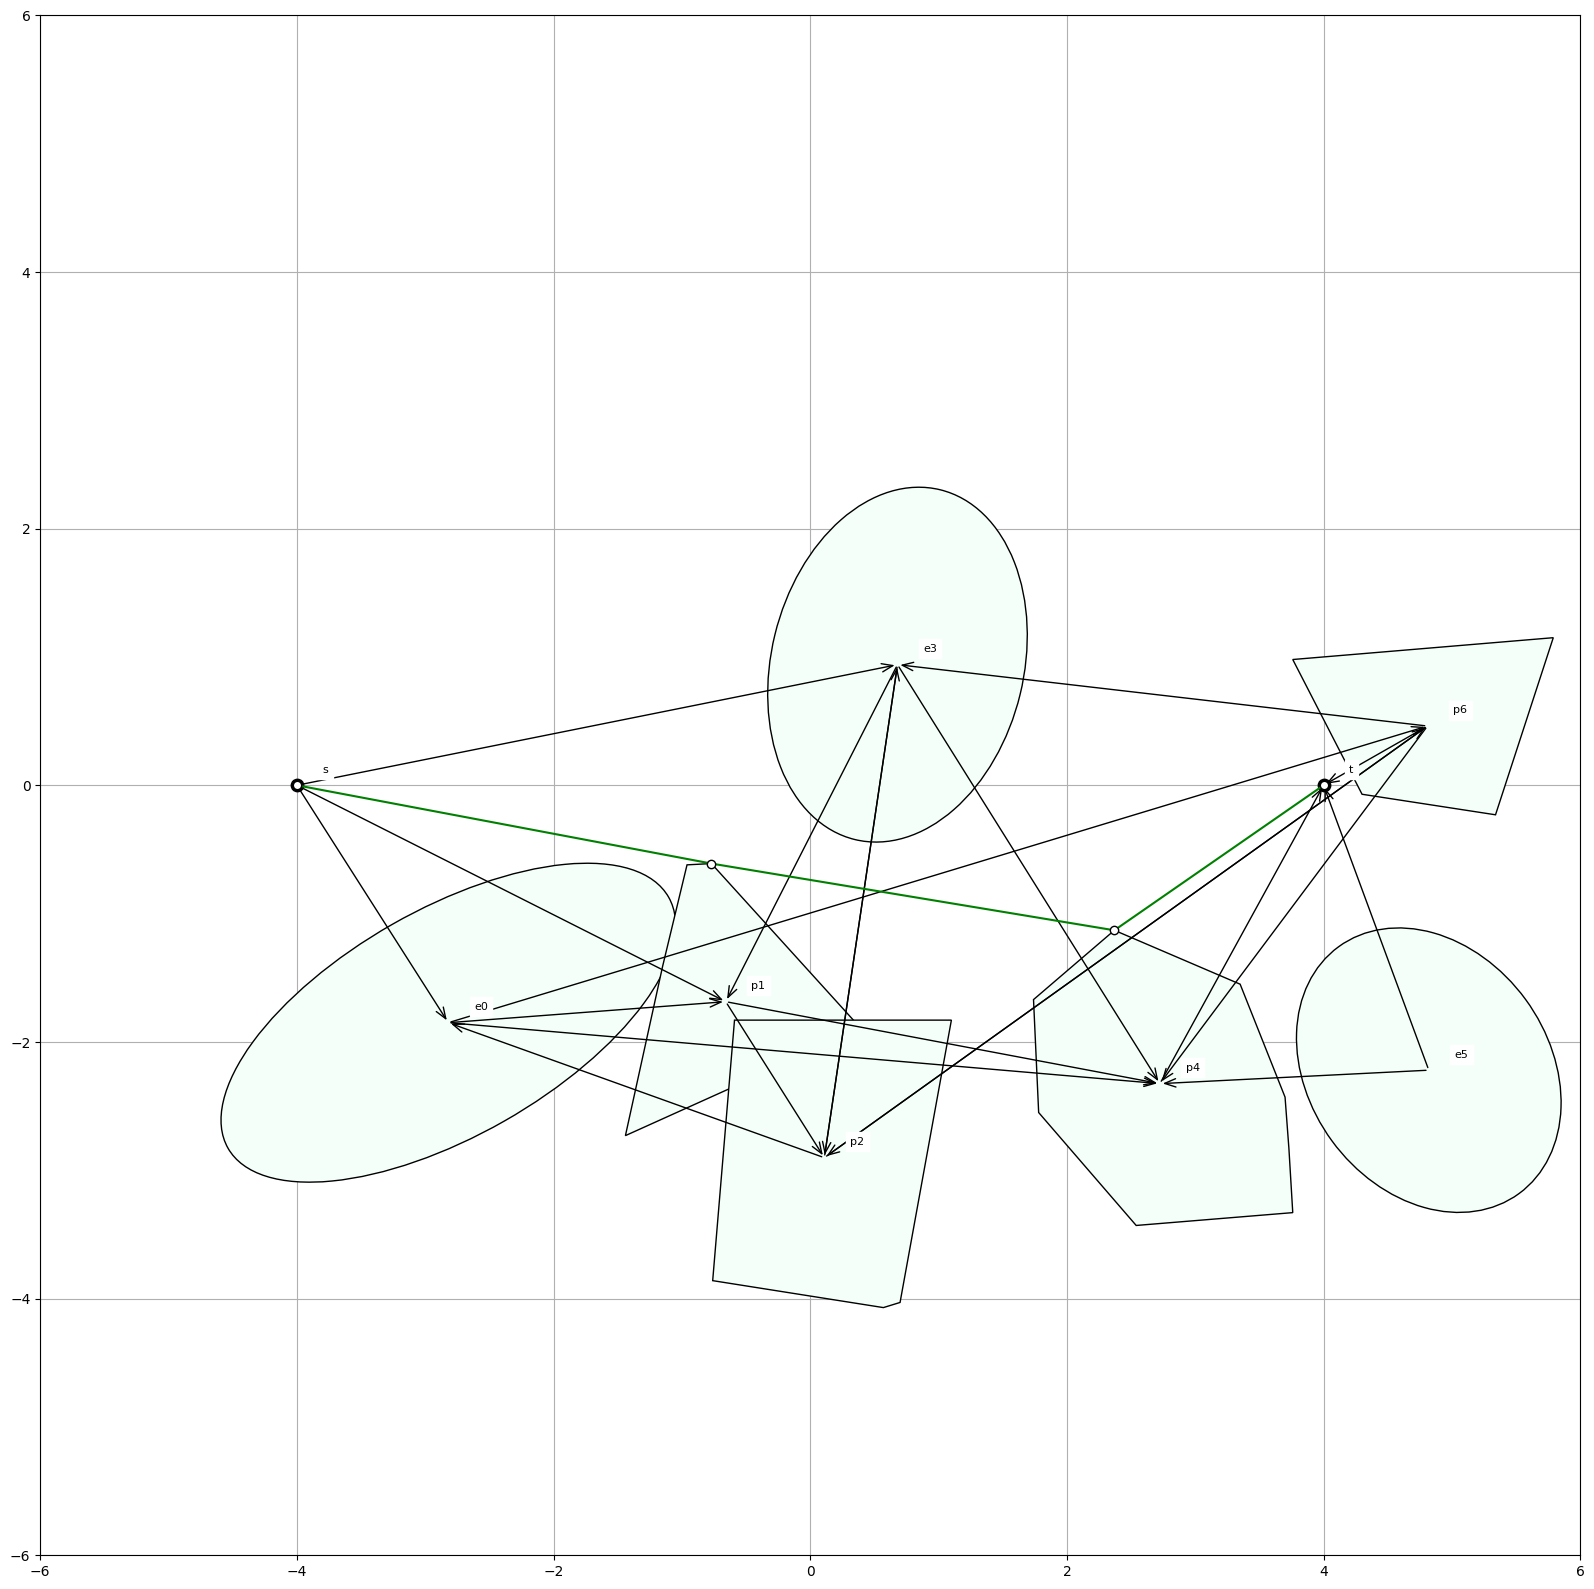

In [3]:
G = load_spp_shape_gcs(file, create_l2norm_edge_cost)
sol = G.solve_shortest_path()

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
G.plot_path(sol.path)
plt.grid()
plt.xlim(np.array(params.workspace[0])* 1.2)
plt.ylim(np.array(params.workspace[1])* 1.2)

plt.show()

In [4]:
data = np.load(file, allow_pickle=True).item()
print(data["params"])

SppShapeGcsGeneratorParams(dim=2, n_sets=7, source=array([-4,  0]), target=array([4, 0]), n_st_edges=3, workspace=array([[-5,  5],
       [-5,  5]]), set_scale=1.2, k_nearest_edges=array([0, 4]), k_nearest_pool=10, n_polyhedron_vertices=array([ 4, 20]), random_seed=804454, save_path='/Users/chewchiashaoyuan/Documents/Software/large_gcs/large_gcs/example_graphs/spp_2d_v7_shape_gcs.npy', should_save=True)
